In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vae_interp.dataset import NpyDataset
from vae_interp.vae import VAE
import matplotlib.pyplot as plt
import torch
from vae_interp.sae import SAE

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
npy_path = "./vae_embeddings.npy"
dataset = NpyDataset(npy_path)

len(dataset)

49859

In [4]:
vae_checkpoint = "./checkpoints/vae"

vae = VAE.load_from_dir(vae_checkpoint)
vae.to("cuda")

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (mu_logvar): Conv2d(256, 8, kernel_siz

In [5]:
dataset[0]

tensor([ 0.3580, -0.7584, -0.7236,  0.2047,  0.4342, -1.0282, -0.5373, -0.3994,
         0.3159,  0.2271,  3.2967, -0.1082,  0.4442, -1.3350,  0.1087, -0.0599,
        -0.1499, -1.4915, -1.1173, -1.1423, -0.7139,  0.3007,  1.9337, -0.5247,
        -0.9506,  1.5348,  1.3062, -0.1191, -0.6700, -0.8807,  0.7381, -0.3178,
        -0.7549,  0.8090, -1.6190, -0.4869, -0.8433, -0.1409,  0.1760, -0.8304,
        -0.9876,  1.4467,  0.5713, -0.5600, -1.0598,  1.9426, -0.2219, -0.9749,
         0.4190,  0.1557, -1.1312,  0.3236,  0.4938, -1.1100, -0.1721,  1.0031,
         0.2506,  0.7770, -1.8356,  0.3198,  0.2038, -0.9374, -1.2771,  0.7020])

In [6]:
# sanity check to make sure it decodes to the right image with VAE
embedding = dataset[1].view(4, 4, 4).unsqueeze(0).to("cuda")
embedding.shape

torch.Size([1, 4, 4, 4])

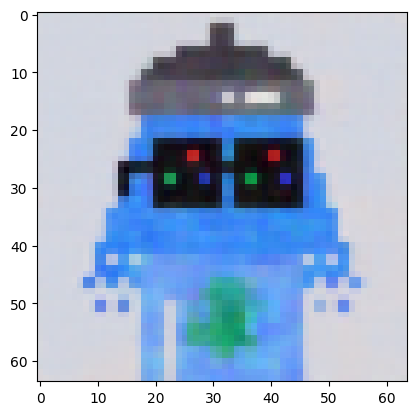

In [7]:
vae.eval()
with torch.no_grad():
    recon = vae.decode(embedding)
    recon = recon.cpu().squeeze(0).permute(1, 2, 0)
    recon = img = (recon - recon.min()) / (recon.max() - recon.min())

plt.imshow(recon)

In [8]:
sae = SAE(
    in_features=4**3,
    expansion_factor=2
)

sae.to("cuda")

SAE()

In [9]:
batch = dataset[0].unsqueeze(0).to("cuda")

In [10]:
sae(batch)

SAEOutput(recon=tensor([[-0.2204, -0.2582,  0.7769, -0.6883, -0.0360, -0.0631,  0.2249, -0.8086,
         -0.6729, -0.1539,  0.1805, -0.9818,  1.0261,  0.2377, -0.5876,  1.4375,
          0.2621, -0.4506,  1.7011,  0.5035, -0.3348, -1.4815,  0.5691,  0.7327,
         -0.9162, -0.4864,  0.6697, -0.4904, -0.4121, -0.4792, -1.6226, -0.7744,
          0.9083,  1.3847,  0.1885,  1.0741,  1.7921, -1.1408, -0.7765,  0.2535,
         -1.3668,  1.4312,  0.4383,  0.1772,  0.8265, -0.7920,  0.6062,  0.9727,
         -1.3108, -1.2641, -1.3318, -0.4320, -1.2782, -1.1927,  1.8402,  0.2533,
          1.1494,  0.5941, -0.0463, -1.0321,  1.6924,  0.5836,  0.9503,  0.8099]],
       device='cuda:0', grad_fn=<AddBackward0>), latent=tensor([[0.4859, 0.3007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9953, 0.0289,
         0.3850, 0.7160, 1.8166, 0.0000, 0.0000, 0.0870, 0.8451, 0.0000, 0.4277,
         1.0829, 0.1497, 0.3995, 0.0000, 0.0000, 0.0000, 0.0000, 1.1392, 0.0000,
         0.0000, 0.4544, 0.0000, 0.

In [11]:
sae.loss(batch, 0.1)

SAELossOutput(loss=tensor(6.2852, device='cuda:0', grad_fn=<AddBackward0>), recon_loss=tensor(1.8090, device='cuda:0'), l1_loss=tensor(4.4761, device='cuda:0'))

In [12]:
from torch.utils.data import DataLoader
from vae_interp.trainer import SAETrainConfig, SAETrainer


dataset = NpyDataset("./vae_embeddings.npy")
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

sae = SAE(
    in_features=64,
    expansion_factor=8,
    dtype=torch.float32,
)

train_config = SAETrainConfig(
    lr=3e-4,
    iterations=10,
    lmbda=0.004,
)
trainer = SAETrainer(
    model=sae,
    dataloader=dataloader,
    config=train_config,
    save_dir="./checkpoints/sae",
    checkpoint_every=10,
    # device=args.device,
)

In [13]:
trainer.get_l0_norm()

Computing L0 norm:   0%|          | 0/390 [00:00<?, ?it/s]

Computing L0 norm: 100%|██████████| 390/390 [00:00<00:00, 914.44it/s] 


264.7004953970196

In [14]:
trainer.get_feature_density()

Computing feature densities:   5%|▌         | 20/390 [00:00<00:01, 199.38it/s]

Computing feature densities: 100%|██████████| 390/390 [00:00<00:00, 997.68it/s] 


tensor([8.2344e-01, 6.3335e-01, 7.3136e-01, 9.8815e-01, 6.9911e-01, 9.0367e-01,
        7.2107e-01, 1.4659e-01, 8.8153e-01, 8.5958e-01, 3.2997e-01, 4.8136e-04,
        6.0011e-01, 2.2692e-01, 3.5624e-01, 1.5975e-01, 8.3403e-01, 4.9740e-02,
        7.2843e-01, 9.4131e-01, 9.2816e-01, 7.8820e-01, 8.5954e-01, 9.8744e-01,
        1.9371e-01, 7.2685e-02, 9.6221e-01, 1.0000e+00, 3.8456e-01, 2.2590e-01,
        3.8258e-01, 9.4125e-02, 3.7947e-02, 8.2633e-03, 6.2637e-01, 8.9960e-01,
        3.4355e-01, 9.9793e-01, 4.0091e-01, 8.4930e-01, 8.9506e-01, 2.5233e-01,
        1.4040e-04, 9.1697e-01, 7.4863e-01, 7.8640e-01, 9.2816e-01, 2.9329e-01,
        8.8937e-01, 6.6267e-02, 5.4143e-01, 9.9354e-01, 6.9281e-01, 3.3334e-02,
        9.2798e-01, 3.7040e-01, 7.4089e-01, 4.4345e-02, 9.9972e-01, 9.8532e-01,
        6.2113e-01, 9.9625e-01, 6.8806e-01, 5.2781e-01, 4.1690e-01, 9.9645e-01,
        5.2147e-04, 8.5457e-01, 2.5291e-02, 2.6013e-02, 9.2539e-01, 2.6294e-02,
        5.0192e-01, 6.7051e-01, 2.2754e-

Computing feature densities:   0%|          | 0/390 [00:00<?, ?it/s]

Computing feature densities: 100%|██████████| 390/390 [00:00<00:00, 1040.31it/s]


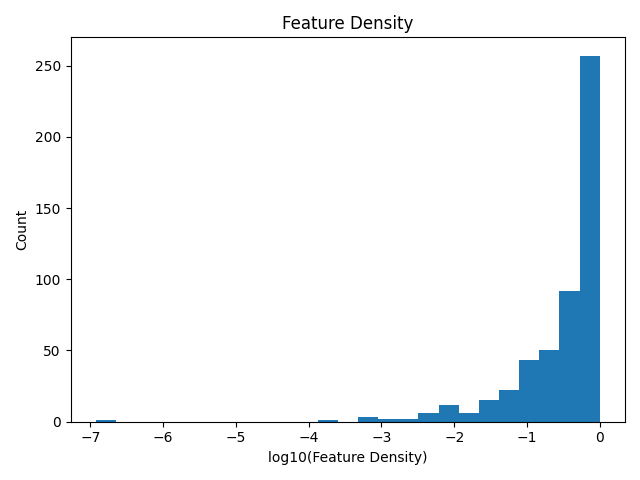

In [16]:
trainer.get_log_feature_density_plot()